# StatReg.jl. package usage example.

Simple RC - chain.

$U_{in} - input, U_{out} - output$

$RC\dot{U}_{out} = -U_{out}+U_{in}$

$RC = \tau$, $$U_{out}(t) = e^{-\frac{t}{\tau}}U_{out}(t=0)+e^{-\frac{t}{\tau}}\int_0^t{e^{\frac{x}{\tau}}U_{in}(x)dx}$$

When $U_{out}(t=0) = 0$ then 
$$U_{out}(t) = \int_0^T{K(x,t)U_{in}(x)dx}$$

$K(x,t) = \begin{cases} e^{\frac{x-t}{\tau}},& x-t<=0\\ 0,& x-t>0 \end{cases}$

Define the kernel:

In [1]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

include("../src/StatReg.jl")
using .StatReg

tau = 1.
function kernel(x::Real, y::Real)
    if x <= y
        return exp( (x-y)/tau)
    end
    return 0.
end

kernel (generic function with 1 method)

Define $T=2\pi, tau = 1,\phi(t)=sin(t)+\cfrac{1}{2} .$ out will be $f(t) = \cfrac{1}{2}(\sin{t}-\cos{t}+1)$

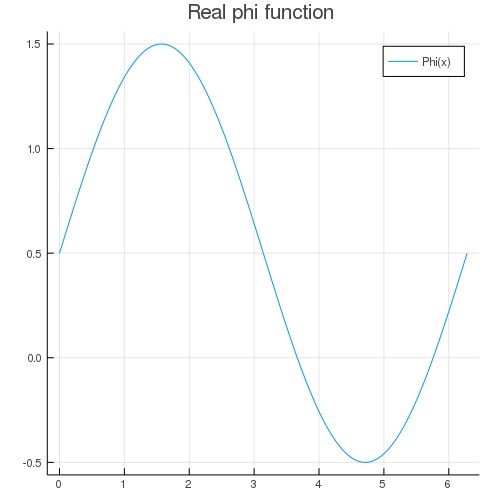

In [2]:
T = 2*pi
a = 0.
b = T

function phi(x::Real)
    return sin(x)+1/2
end
function f_expected(y::Real)
    return (sin(y)-cos(y)+1)/2
end

#creating x array
x = collect(range(a, stop=b, length=1000))
phi_plot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])

Then, define $f(y)$ - the resulting function.

In [3]:
x = collect(range(a, stop=b, length=20))
f_clear = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]

#3 (generic function with 1 method)

In [4]:
plot_expected_f = plot(x, f_expected.(x))
plot_clear_f = plot(x, f_clear.(x))
gca().legend(("f_expected","f_clear"))
gca().grid()
title("compering of f = K(x,y)*phi(x)dx and f(t) = 1/2(sin(t)-...)\nalmost the same")

UndefVarError: UndefVarError: quadgk not defined

Than add a noise   

In [5]:
f_clear_array = f_clear.(x)
eps = 0.05
#change eps and observe the difference
max_eps_array = [eps for i = 1:Base.length(f_clear_array)]

using Compat, Random, Distributions

noise_array = []
for sigma in max_eps_array
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise_array, n)
end

f_measured_array = f_clear_array + noise_array
plot(x,f_clear_array)
plot(x,f_measured_array)
gca().legend(("f_clear","f_measured"))
gca().grid()
title("comparing f_clear = K(x,y)*phi(x)dx and this ading a noise")

UndefVarError: UndefVarError: quadgk not defined

Now, we choose a basis (for example, FourierBasis, other options can be found in docs).

In [6]:
num_of_basis_functions = Int(10)

work_basis_fourier  = FourierBasis(a, b, num_of_basis_functions)
#10 harmonics => 21 functions including harmony of Freq = 0, f = 0.5
work_basis_legendre = LegendreBasis(a,b,num_of_basis_functions)

x_high_prec_array = collect(range(a, stop=b, length=300))

for index =1:5
    plot(x_high_prec_array, work_basis_fourier.basis_functions[index].f.(x_high_prec_array))
end
gca().legend("12345")
title("fourier basis functions")



┌ Info: Fourier basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:118
┌ Info: Legendre polynomials basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:332


UndefVarError: UndefVarError: gca not defined

In [7]:
for index =1:6
    plot(x_high_prec_array, work_basis_legendre.basis_functions[index].f.(x_high_prec_array))
end
gca().legend("123456")
title("legendre basis functions")

UndefVarError: UndefVarError: gca not defined

Now, we define a quadratic form of smoothing operator $\Omega$

In [8]:
order_of_diff = Int(1) # = 1,the problem is that only 1 is Int32(1)
operator_omega_fourier = omega(work_basis_fourier,order_of_diff)
operator_omega_legendre = omega(work_basis_legendre,order_of_diff)
matshow(operator_omega_fourier)
colorbar()
title("operator omega in fourier basis")
matshow(operator_omega_legendre)
colorbar()
title("operator omega in legendre basis")

┌ Info: Calculating omega matrix for Fourier basis derivatives of order 1...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:125
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:141
┌ Info: Calculating omega matrix for Legendre polynomials basis derivatives of order 1...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:339
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/basis.jl:365


UndefVarError: UndefVarError: matshow not defined

Next step is to define the model

In [9]:
model_geu_fourier = GaussErrorUnfolder(work_basis_fourier, [operator_omega_fourier])
model_geu_legendre = GaussErrorUnfolder(work_basis_legendre, [operator_omega_legendre])
println()

┌ Error: Lower limits of alphas should be provided for method=EmpiricalBayes
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/check.jl:53


ErrorException: Lower limits of alphas should be provided for method=EmpiricalBayes

Then we can get reconstructed function $\phi(x)$ by method `solve`

We will get phi_reconst_fourier and phi_reconst_legendre

Also, we can easily get reconstrution of $\phi(x)$ by substitution $f(x)$ in equatation 

$\tau\dot{U}_{out} = -U_{out}+U_{in}$

So, as $U_{in} = \phi, U_{out} = f(x), \tau = 1$

then $\phi(x) = f(x)+\dot{f(}x)$

The only problem is that noise after differentiation can turn to a very hopping function (graph "reconstructions")

So, let's reconstruct by StatReg

In [10]:
phi_reconst_fourier = solve(model_geu_fourier, kernel, f_measured_array, max_eps_array, x)
phi_reconst_legendre = solve(model_geu_legendre, kernel, f_measured_array, max_eps_array, x)

UndefVarError: UndefVarError: model_geu_fourier not defined

In [11]:
phi_reconst_from_fourier = PhiVec(phi_reconst_fourier["coeff"], work_basis_fourier, phi_reconst_fourier["errors"])
phi_reconst_from_legendre = PhiVec(phi_reconst_legendre["coeff"], work_basis_legendre, phi_reconst_legendre["errors"])
println()

UndefVarError: UndefVarError: phi_reconst_fourier not defined

Reconstructing by the straight method $\phi(x) = f(x)+\dot{f(}x)$

In [12]:
dfdx = []
for i=1:(length(f_measured_array)-1)
    push!(dfdx, (f_measured_array[i+1]-f_measured_array[i])/(x[i+1]-x[i]) )
end
push!(dfdx,dfdx[length(f_measured_array)-1])
phi_straight = dfdx + f_measured_array
println()

UndefVarError: UndefVarError: f_measured_array not defined

In [13]:
phi_reconst_legendre_values = phi_reconst_from_legendre.phi_function.(x)
phi_reconst_legendre_errors = phi_reconst_from_legendre.error_function.(x)

phi_reconst_fourier_values = phi_reconst_from_fourier.phi_function.(x)
phi_reconst_fourier_errors = phi_reconst_from_fourier.error_function.(x)

plot(x,phi.(x))
plot(x,phi_reconst_legendre_values)
plot(x,phi_reconst_fourier_values)
plot(x,phi_straight)
gca().legend(("phi_real","phi_reconstructed_legendre","phi_reconst_fourier","phi_straight"))
gca().grid()
title("reconstructions")
println()

UndefVarError: UndefVarError: phi_reconst_from_legendre not defined